http://cedro3.com/ai/keras-anogan-anomaly/

In [1]:
from keras.utils. generic_utils import Progbar
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Flatten
from keras.layers.core import Activation
from keras.optimizers import Adam
import keras.backend as K
import math, cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
#from keras.datasets import fashion_mnist

Using TensorFlow backend.


### パラメータ

In [2]:
BATCH = 16 # バッチサイズ
EPOCH = 300 # エポック数
DIM   = 30  # 入力する次元数
LR    = 0.001 # 学習率

### Generator

In [3]:
class Generator(object):
    def __init__(self, input_dim, image_shape):
        INITIAL_CHANNELS = 128
        INITIAL_SIZE = 7
 
        inputs = Input((input_dim,))
        fc1 = Dense(input_dim=input_dim, units=INITIAL_CHANNELS * INITIAL_SIZE * INITIAL_SIZE)(inputs)
        fc1 = BatchNormalization()(fc1)
        fc1 = LeakyReLU(0.2)(fc1)
        fc2 = Reshape((INITIAL_SIZE, INITIAL_SIZE, INITIAL_CHANNELS), input_shape=(INITIAL_CHANNELS * INITIAL_SIZE * INITIAL_SIZE,))(fc1)
        up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
        conv1 = Conv2D(64, (3, 3), padding='same')(up1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)
        up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
        conv2 = Conv2D(image_shape[2], (5, 5), padding='same')(up2)
        outputs = Activation('tanh')(conv2)
 
        self.model = Model(inputs=[inputs], outputs=[outputs])
 
    def get_model(self):
        return self.model

### Discriminator

In [4]:
class Discriminator(object):
    def __init__(self, input_shape):
        inputs = Input(input_shape)
        conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
        conv1 = LeakyReLU(0.2)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
        conv2 = LeakyReLU(0.2)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        fc1 = Flatten()(pool2)
        fc1 = Dense(1)(fc1)
        outputs = Activation('sigmoid')(fc1)
 
        self.model = Model(inputs=[inputs], outputs=[outputs])
 
    def get_model(self):
        return self.model

### DCGAN

In [5]:
class DCGAN(object):
    def __init__(self, input_dim, image_shape):
        self.input_dim = input_dim
        self.d = Discriminator(image_shape).get_model()
        self.g = Generator(input_dim, image_shape).get_model()
 
    def compile(self, g_optim, d_optim):
        self.d.trainable = False
        self.dcgan = Sequential([self.g, self.d])
        self.dcgan.compile(loss='binary_crossentropy', optimizer=g_optim)
        self.d.trainable = True
        self.d.compile(loss='binary_crossentropy', optimizer=d_optim)
 
    def train(self, epochs, batch_size, X_train):
        g_losses = []
        d_losses = []
        for epoch in range(epochs):
            np.random.shuffle(X_train)
            n_iter = X_train.shape[0] // batch_size
            progress_bar = Progbar(target=n_iter)
            for index in range(n_iter):
                # create random noise -> N latent vectors
                noise = np.random.uniform(-1, 1, size=(batch_size, self.input_dim))
 
                # load real data & generate fake data
                image_batch = X_train[index * batch_size:(index + 1) * batch_size]
                for i in range(batch_size):
                    if np.random.random() > 0.5:
                        image_batch[i] = np.fliplr(image_batch[i])
                    if np.random.random() > 0.5:
                        image_batch[i] = np.flipud(image_batch[i])
                generated_images = self.g.predict(noise, verbose=0)
 
                # attach label for training discriminator
                X = np.concatenate((image_batch, generated_images))
                y = np.array([1] * batch_size + [0] * batch_size)
 
                # training discriminator
                d_loss = self.d.train_on_batch(X, y)
 
                # training generator
                g_loss = self.dcgan.train_on_batch(noise, np.array([1] * batch_size))
 
                progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])
            g_losses.append(g_loss)
            d_losses.append(d_loss)
            if (epoch+1)%10 == 0:
                image = self.combine_images(generated_images)
                image = (image + 1) / 2.0 * 255.0
                cv2.imwrite('./result/' + str(epoch) + ".png", image)
            print('\nEpoch' + str(epoch) + " end")
 
            # save weights for each epoch
            if (epoch+1)%50 == 0:
                self.g.save_weights('weights/generator_' + str(epoch) + '.h5', True)
                self.d.save_weights('weights/discriminator_' + str(epoch) + '.h5', True)
        return g_losses, d_losses
 
    def load_weights(self, g_weight, d_weight):
        self.g.load_weights(g_weight)
        self.d.load_weights(d_weight)
 
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num) / width))
        shape = generated_images.shape[1:4]
        image = np.zeros((height * shape[0], width * shape[1], shape[2]),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            i = int(index / width)
            j = index % width
            image[i * shape[0]:(i + 1) * shape[0], j * shape[1]:(j + 1) * shape[1], :] = img[:, :, :]
        return image

### AnoGAN

In [6]:
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

In [7]:
class ANOGAN(object):
    def __init__(self, input_dim, g):
        self.input_dim = input_dim
        self.g = g
        g.trainable = False
        # Input layer cann't be trained. Add new layer as same size & same distribution
        anogan_in = Input(shape=(input_dim,))
        g_in = Dense((input_dim), activation='tanh', trainable=True)(anogan_in)
        g_out = g(g_in)
        self.model = Model(inputs=anogan_in, outputs=g_out)
        self.model_weight = None
 
    def compile(self, optim):
        self.model.compile(loss=sum_of_residual, optimizer=optim)
        K.set_learning_phase(0)
 
    def compute_anomaly_score(self, x, iterations=300):
        z = np.random.uniform(-1, 1, size=(1, self.input_dim))
 
        # learning for changing latent
        loss = self.model.fit(z, x, batch_size=1, epochs=iterations, verbose=0)
        loss = loss.history['loss'][-1]
        similar_data = self.model.predict_on_batch(z)
 
        return loss, similar_data

### train

In [8]:
if __name__ == '__main__':
    batch_size = BATCH
    epochs = EPOCH
    input_dim = DIM
    g_optim = Adam(lr=LR, beta_1=0.5, beta_2=0.999)
    d_optim = Adam(lr=LR, beta_1=0.5, beta_2=0.999)
  
    # データセットの読み込み
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()  # Fashion MNIST 
    
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
  
    # 学習データの作成
    x_train_1 = []
    for i in range(len(x_train)):
        if y_train[i] == 1: 
           x_train_1.append(x_train[i].reshape((28, 28, 1))) 
    x_train_1 = np.array(x_train_1)
    print("train data:",len(x_train_1))
  
    # 評価データの作成
    cnt = 0
    x_test_9, y = [], []
    for i in range(len(x_test)):
        if y_test[i] == 1 or y_test[i] == 9:  
           x_test_9.append(x_test[i].reshape((28, 28, 1))) 
           y.append(y_test[i])
           cnt +=1
           if cnt == 100:
              break           
    x_test_9 = np.array(x_test_9)
    print("test_data:",len(x_test_9))    
    input_shape = x_train_1[0].shape   
    X_test_original = x_test_9.copy()    
 
   
    # train generator & discriminator
    dcgan = DCGAN(input_dim, input_shape)
    dcgan.compile(g_optim, d_optim)
    g_losses, d_losses = dcgan.train(epochs, batch_size, x_train_1)  
    with open('loss.csv', 'w') as f:
        for g_loss, d_loss in zip(g_losses, d_losses):
            f.write(str(g_loss) + ',' + str(d_loss) + '\n')

train data: 6742
test_data: 100


C:\Users\shimizukoji\anaconda3\envs\AnoGAN\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  6/421 [..............................] - ETA: 5:53 - g: 0.7368 - d: 0.4697   

C:\Users\shimizukoji\anaconda3\envs\AnoGAN\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


420/421 [============================>.] - ETA: 0s - g: 2.4769 - d: 0.0378
Epoch0 end
420/421 [============================>.] - ETA: 0s - g: 5.5611 - d: 0.1510
Epoch1 end
420/421 [============================>.] - ETA: 0s - g: 3.8372 - d: 0.1650
Epoch2 end
420/421 [============================>.] - ETA: 0s - g: 3.5484 - d: 0.2162
Epoch3 end
420/421 [============================>.] - ETA: 0s - g: 4.9051 - d: 0.1536
Epoch4 end
420/421 [============================>.] - ETA: 0s - g: 7.0900 - d: 0.1242
Epoch5 end
420/421 [============================>.] - ETA: 0s - g: 5.5515 - d: 0.1358
Epoch6 end
420/421 [============================>.] - ETA: 0s - g: 6.7821 - d: 0.0708
Epoch7 end
420/421 [============================>.] - ETA: 0s - g: 7.1436 - d: 0.1116
Epoch8 end
420/421 [============================>.] - ETA: 0s - g: 6.0151 - d: 0.1167
Epoch9 end
420/421 [============================>.] - ETA: 0s - g: 8.3645 - d: 0.0532
Epoch10 end
420/421 [============================>.] - ETA: 0s - 

### test

In [9]:
K.set_learning_phase(1)

In [10]:
def denormalize(X):
    return ((X + 1.0)/2.0*255.0).astype(dtype=np.uint8)

0 41.93
1 57.37
2 85.13
3 124.99
4 92.21
5 66.63
6 92.39
7 110.31
8 53.33
9 45.69
10 56.95
11 74.76
12 30.14
13 77.89
14 43.42
15 105.87
16 56.82
17 117.93
18 61.84
19 82.68
20 69.33
21 60.14
22 93.03
23 49.40
24 122.29
25 88.15
26 82.63
27 57.63
28 91.85
29 93.43
30 69.06
31 76.95
32 72.58
33 82.40
34 48.28
35 45.75
36 94.00
37 122.06
38 41.90
39 59.09
40 33.70
41 55.45
42 50.46
43 91.48
44 39.01
45 86.90
46 53.67
47 85.19
48 77.36
49 51.89
50 37.53
51 43.18
52 113.57
53 124.68
54 122.01
55 123.17
56 30.33
57 51.51
58 75.16
59 49.24
60 118.33
61 39.12
62 117.97
63 77.02
64 72.20
65 69.73
66 48.69
67 112.87
68 128.55
69 64.48
70 40.04
71 105.01
72 88.84
73 64.86
74 112.27
75 52.67
76 61.20
77 124.09
78 66.31
79 102.25
80 65.72
81 53.78
82 55.30
83 113.55
84 56.65
85 72.47
86 60.53
87 72.36
88 51.54
89 32.95
90 114.73
91 43.82
92 45.54
93 39.81
94 49.39
95 101.86
96 51.28
97 66.83
98 62.45
99 77.59


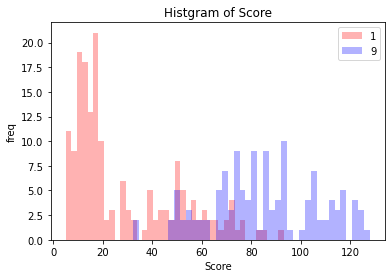

In [11]:
if __name__ == '__main__':
    iterations = 100
    input_dim = 30
    anogan_optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
 
    # load weights
    dcgan = DCGAN(input_dim, input_shape)
    dcgan.load_weights('weights/generator_99.h5', 'weights/discriminator_99.h5')  #3999.99
 
    for i, test_img in enumerate(x_test_9):  
        test_img = test_img[np.newaxis,:,:,:]
        anogan = ANOGAN(input_dim, dcgan.g)
        anogan.compile(anogan_optim)
        anomaly_score, generated_img = anogan.compute_anomaly_score(test_img, iterations)
 
        generated_img = denormalize(generated_img)
        imgs = np.concatenate((denormalize(test_img[0]), generated_img[0]), axis=1)
        cv2.imwrite('predict' + os.sep + str(int(anomaly_score)) + '_' + str(i) + '.png', imgs)
        print(str(i) + ' %.2f'%anomaly_score)
 
        if y[i] == 1 :       
           with open('scores_1.txt', 'a') as f:
                f.write(str(anomaly_score) + '\n')
        else:
           with open('scores_9.txt', 'a') as f:
                f.write(str(anomaly_score) + '\n') 
    
    # plot histgram
    import matplotlib.pyplot as plt
    import csv
    
    x =[]
    with open('scores_1.txt', 'r') as f:
         reader = csv.reader(f)
         for row in reader:
             row = int(float(row[0]))
             x.append(row)
    y =[]
    with open('scores_9.txt', 'r') as f:
         reader = csv.reader(f)
         for row in reader:
             row = int(float(row[0]))
             y.append(row)
             
    plt.title("Histgram of Score")
    plt.xlabel("Score")
    plt.ylabel("freq")
    plt.hist(x, bins=40, alpha=0.3, histtype='stepfilled', color='r', label="1")
    plt.hist(y, bins=40, alpha=0.3, histtype='stepfilled', color='b', label='9')
    plt.legend(loc=1)
    plt.savefig("histgram.png")
    plt.show()
    plt.close()